In [2]:
import os
import anndata
import crested
import pandas as pd

In [3]:
data_files_root = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_data/anndatas"
anndata_10x_path = os.path.join(data_files_root, "10x_allcells_allreads/normalized_specific.h5ad")
anndata_hydrop_path = os.path.join(data_files_root, "hydrop_allcells_allreads/normalized_specific.h5ad")
model_folder_10x = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned/10x_allcells_allreads"
model_folder_hydrop = "../../../../../../../data/hydrop_v2_paper/mcortex/paper_zips/10x_hydropv2_comparisons_models/finetuned/hydrop_allcells_allreads"

genome_path = "../../../../../../../data/genomes/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"

In [4]:
genome = crested.Genome(genome_path, name="mm10")
crested.register_genome(genome)

2025-07-29T09:51:42.267406+0200 INFO Genome mm10 registered.


## Load data

In [5]:
adata_hydrop = anndata.read_h5ad(anndata_hydrop_path)
adata_10x = anndata.read_h5ad(anndata_10x_path)

In [6]:
print(adata_hydrop.obs_names)

# subset on celltypes of interest
ct_of_interest = ["Astro","Oligo", "Micro_PVM", "L2_3_IT","L5_ET","L6_IT"]
class_idx_hydrop = list(adata_hydrop.obs_names.get_indexer(ct_of_interest))
print(class_idx_hydrop)

class_idx_10x = list(adata_10x.obs_names.get_indexer(ct_of_interest))
print(class_idx_10x)

Index(['Astro', 'Endo_VLMC', 'L2_3_IT', 'L5_6_NP', 'L5_ET', 'L5_IT', 'L6_CT',
       'L6_IT', 'L6b', 'Lamp5', 'Micro_PVM', 'OPC', 'Oligo', 'Pvalb',
       'Sncg_Vip', 'Sst'],
      dtype='object')
[np.int64(0), np.int64(12), np.int64(10), np.int64(2), np.int64(4), np.int64(7)]
[np.int64(0), np.int64(12), np.int64(10), np.int64(2), np.int64(4), np.int64(7)]


# Load Model and select regions for prediction

In [7]:
# take the same regions for both hydrop and 10x. Most regions are already the same in both anndata, but we take 10x as the base since it has slightly fewer regions
regions_of_interest = list(adata_10x.var_names)
regions_of_interest[0:3]

['chr1:3093479-3095593', 'chr1:3164933-3167047', 'chr1:3288841-3290955']

In [7]:
seqs = [genome.fetch(region=region) for region in regions_of_interest]

In [ ]:
import keras

models_hydrop = []
for model_path_hydrop in os.listdir(model_folder_hydrop):
    if model_path_hydrop.endswith(".keras"):
        models_hydrop.append(keras.models.load_model(os.path.join(model_folder_hydrop, model_path_hydrop)))

I0000 00:00:1753525434.847984 1728208 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0


In [9]:
import numpy as np

one_hots = np.array(
    [crested.utils.one_hot_encode_sequence(seq, expand_dim=False) for seq in seqs]
)

In [10]:
# predict on the regions of 10x
preds_hydrop = crested.tl.predict(
    input=one_hots,
    model=models_hydrop # will average predictions over 10 models
)

I0000 00:00:1753525445.617179 1728409 service.cc:152] XLA service 0x7fb878003560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753525445.617201 1728409 service.cc:160]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2025-07-26 12:24:05.640161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753525445.735256 1728409 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-26 12:24:06.724813: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_450', 4 bytes spill stores, 4 bytes spill loads



2025-07-26 12:24:09.069327: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv.10 = (f32[256,512,1,1055]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,512,1,1057]{3,2,1,0} %bitcast.1740, f32[512,512,1,3]{3,2,1,0} %bitcast.1745), window={size=1x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_7_1/bpnet_1conv_1/convolution" source_file="/data/groups/vib.ai/stein.aerts/lmahieu/software/miniconda3/envs/crested/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-07-26 12:24:09.262931: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.193708907s
Trying algorithm en

   3/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 54ms/step 

I0000 00:00:1753525464.275113 1728409 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 68ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 57ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step


In [11]:
preds_hydrop_df = pd.DataFrame(
    preds_hydrop[:, class_idx_hydrop].T,
    columns=regions_of_interest,
    index= ct_of_interest,
).T

In [12]:
preds_hydrop_df

Astro     Oligo  Micro_PVM   L2_3_IT     L5_ET  \
chr1:3093479-3095593      0.031225  0.012117   0.006456  0.059813  0.081231   
chr1:3164933-3167047      0.008461  0.009123   0.004902  0.037426  0.044455   
chr1:3288841-3290955      0.008539  0.012007   0.004201  0.039505  0.054394   
chr1:3534483-3536597      0.006373  0.010673   0.118140  0.016386  0.020519   
chr1:3613397-3615511      0.010072  0.031077   0.010301  0.019517  0.018051   
...                            ...       ...        ...       ...       ...   
chrX:167145591-167147705  0.033180  0.036965   0.163162  0.446649  0.826807   
chrX:18764081-18766195    0.017904  0.019217   0.007647  0.183274  0.128961   
chrX:93293267-93295381    0.038142  0.018668   0.006548  0.092604  0.124704   
chrY:1049373-1051487      0.009522  0.005400   0.004511  0.071721  0.103611   
chrY:1244730-1246844      0.022243  0.009542   0.014103  0.060978  0.073922   

                             L6_IT  
chr1:3093479-3095593      0.061037  
chr1:3164933-3167047      0.043376  
chr1:3288841-3290955      0.037608  
chr1:3534483-3536597      0.017728  
chr1:3613397-3615511      0.027597  
...                            ...  
chrX:167145591-167147705  0.917871  
chrX:18764081-18766195    0.280720  
chrX:93293267-93295381    0.091824  
chrY:1049373-1051487      0.049067  
chrY:1244730-1246844      0.054049  

[127944 rows x 6 columns]

## 10x

In [ ]:
models_10x = []
for model_path_10x in os.listdir(model_folder_10x):
    if model_path_10x.endswith(".keras"):
        models_10x.append(keras.models.load_model(os.path.join(model_folder_10x, model_path_10x)))

In [14]:
preds_10x = crested.tl.predict(
    input=one_hots,
    model=models_10x
)

  26/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 58ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step


In [15]:
preds_10x_df = pd.DataFrame(
    preds_10x[:, class_idx_10x].T,
    columns=regions_of_interest,
    index=ct_of_interest,
).T

In [16]:
preds_10x_df

Astro     Oligo  Micro_PVM   L2_3_IT     L5_ET  \
chr1:3093479-3095593      0.064779  0.012508   0.007910  0.065204  0.091783   
chr1:3164933-3167047      0.012794  0.010288   0.006003  0.046244  0.054456   
chr1:3288841-3290955      0.011327  0.012312   0.005236  0.038845  0.055091   
chr1:3534483-3536597      0.008641  0.008097   0.040166  0.022431  0.028968   
chr1:3613397-3615511      0.012946  0.026055   0.010226  0.024296  0.027892   
...                            ...       ...        ...       ...       ...   
chrX:167145591-167147705  0.033678  0.037933   0.122132  0.393677  0.904149   
chrX:18764081-18766195    0.017086  0.013609   0.007347  0.126557  0.089385   
chrX:93293267-93295381    0.045118  0.021523   0.013744  0.096110  0.139808   
chrY:1049373-1051487      0.014143  0.007691   0.006098  0.067299  0.087528   
chrY:1244730-1246844      0.017547  0.008448   0.015583  0.029308  0.047152   

                             L6_IT  
chr1:3093479-3095593      0.076120  
chr1:3164933-3167047      0.054327  
chr1:3288841-3290955      0.039058  
chr1:3534483-3536597      0.023516  
chr1:3613397-3615511      0.035863  
...                            ...  
chrX:167145591-167147705  0.991603  
chrX:18764081-18766195    0.204987  
chrX:93293267-93295381    0.099106  
chrY:1049373-1051487      0.049455  
chrY:1244730-1246844      0.028865  

[127944 rows x 6 columns]

# Select Overlapping Regions in Top 2k

In [17]:
preds_hydrop = preds_hydrop_df
preds_10x = preds_10x_df

top_k = 2000
overlap_regions = {}
for i, selected_class in enumerate(preds_hydrop.columns):
    preds_sorted = preds_hydrop.sort_values(selected_class, ascending=False).head(top_k)
    selected_regions = set(preds_sorted.index)
    
    preds_sorted_multiome = preds_10x.sort_values(selected_class, ascending=False).head(top_k)
    selected_regions_multiome = set(preds_sorted_multiome.index)

    overlap = selected_regions.intersection(selected_regions_multiome)
    overlap_regions[selected_class] = overlap

    print(f"{selected_class}: {len(overlap)}")

    # save the regions to a .bed file (tsv)
    with open(f"../data/modisco/selected_regions/{selected_class}.bed", "w") as f:
        for region in overlap:
            chrom, start_end = region.split(":")
            start, end = start_end.split("-")
            f.write(f"{chrom}\t{start}\t{end}\n")

    # contrib scores hydrop for this class
    if not os.path.exists(f"../data/modisco/modisco_results_hydrop/{selected_class}_contrib.npz"):
        target_id = [class_idx_hydrop[i]]
        crested.tl.contribution_scores(
            input=list(overlap),
            target_idx=target_id,
            model=models_hydrop,
            output_dir="../data/modisco/modisco_results_hydrop",
            transpose=True,
            all_class_names=list(adata_hydrop.obs_names),
            method="integrated_grad",
        )

    # contrib scores multiome for this class
    if not os.path.exists(f"../data/modisco/modisco_results_10x/{selected_class}_contrib.npz"):
        target_id = [class_idx_10x[i]]
        crested.tl.contribution_scores(
            input=list(overlap),
            target_idx=target_id,
            model=models_10x,
            output_dir="../data/modisco/modisco_results_10x",
            transpose=True,
            all_class_names=list(adata_10x.obs_names),
            method="integrated_grad",
        )

Astro: 1720
Oligo: 1775
Micro_PVM: 1730
2025-07-26T12:44:29.205690+0200 INFO Calculating contribution scores for 1 class(es) and 1730 region(s).


Model:   0%|          | 0/10 [00:00<?, ?it/s]

Model: 100%|██████████| 10/10 [23:38<00:00, 141.87s/it]


2025-07-26T13:08:19.713756+0200 INFO Calculating contribution scores for 1 class(es) and 1730 region(s).


Model: 100%|██████████| 10/10 [23:12<00:00, 139.28s/it]


L2_3_IT: 1652
2025-07-26T13:31:44.055877+0200 INFO Calculating contribution scores for 1 class(es) and 1652 region(s).


Model: 100%|██████████| 10/10 [22:06<00:00, 132.60s/it]


2025-07-26T13:54:00.997064+0200 INFO Calculating contribution scores for 1 class(es) and 1652 region(s).


Model: 100%|██████████| 10/10 [22:02<00:00, 132.25s/it]


L5_ET: 1523
2025-07-26T14:16:14.761264+0200 INFO Calculating contribution scores for 1 class(es) and 1523 region(s).


Model: 100%|██████████| 10/10 [20:17<00:00, 121.75s/it]


2025-07-26T14:36:42.237278+0200 INFO Calculating contribution scores for 1 class(es) and 1523 region(s).


Model: 100%|██████████| 10/10 [20:21<00:00, 122.17s/it]


L6_IT: 1643
2025-07-26T14:57:14.059432+0200 INFO Calculating contribution scores for 1 class(es) and 1643 region(s).


Model: 100%|██████████| 10/10 [21:51<00:00, 131.15s/it]


2025-07-26T15:19:16.432007+0200 INFO Calculating contribution scores for 1 class(es) and 1643 region(s).


Model: 100%|██████████| 10/10 [21:51<00:00, 131.11s/it]


# TF Modisco

In [ ]:
# best run these as slurm jobs
import crested

In [ ]:
# run tfmodisco on the contribution scores
crested.tl.modisco.tfmodisco(
    window=1000,
    output_dir="../data/modisco/modisco_results_hydrop",
    contrib_dir="../data/modisco/modisco_results_hydrop",
    meme_db="../../../../../../../data/groups/vib.ai/stein.aerts/lmahieu/data/motifs-v10-nr.cluster.mgi-m0.00001-o0.0.ensembl108_collNames.meme",
    report=True,
    max_seqlets=20000,
)

In [ ]:
crested.tl.tfmodisco(
    window=1000,
    output_dir="../data/modisco/modisco_results_10x",
    contrib_dir="../data/modisco/modisco_results_10x",
    report=True,  # Optional, will match patterns to motif MEME database
    meme_db="/data/groups/vib.ai/stein.aerts/lmahieu/data/motifs-v10-nr.cluster.mgi-m0.00001-o0.0.ensembl108_collNames.meme",
    max_seqlets=20000,
)

## Plot results

2025-07-28T11:36:40.047470+0200 INFO Starting genomic contributions plot for classes: ['Astro', 'Oligo', 'Micro_PVM', 'L2_3_IT', 'L5_ET', 'L6_IT']


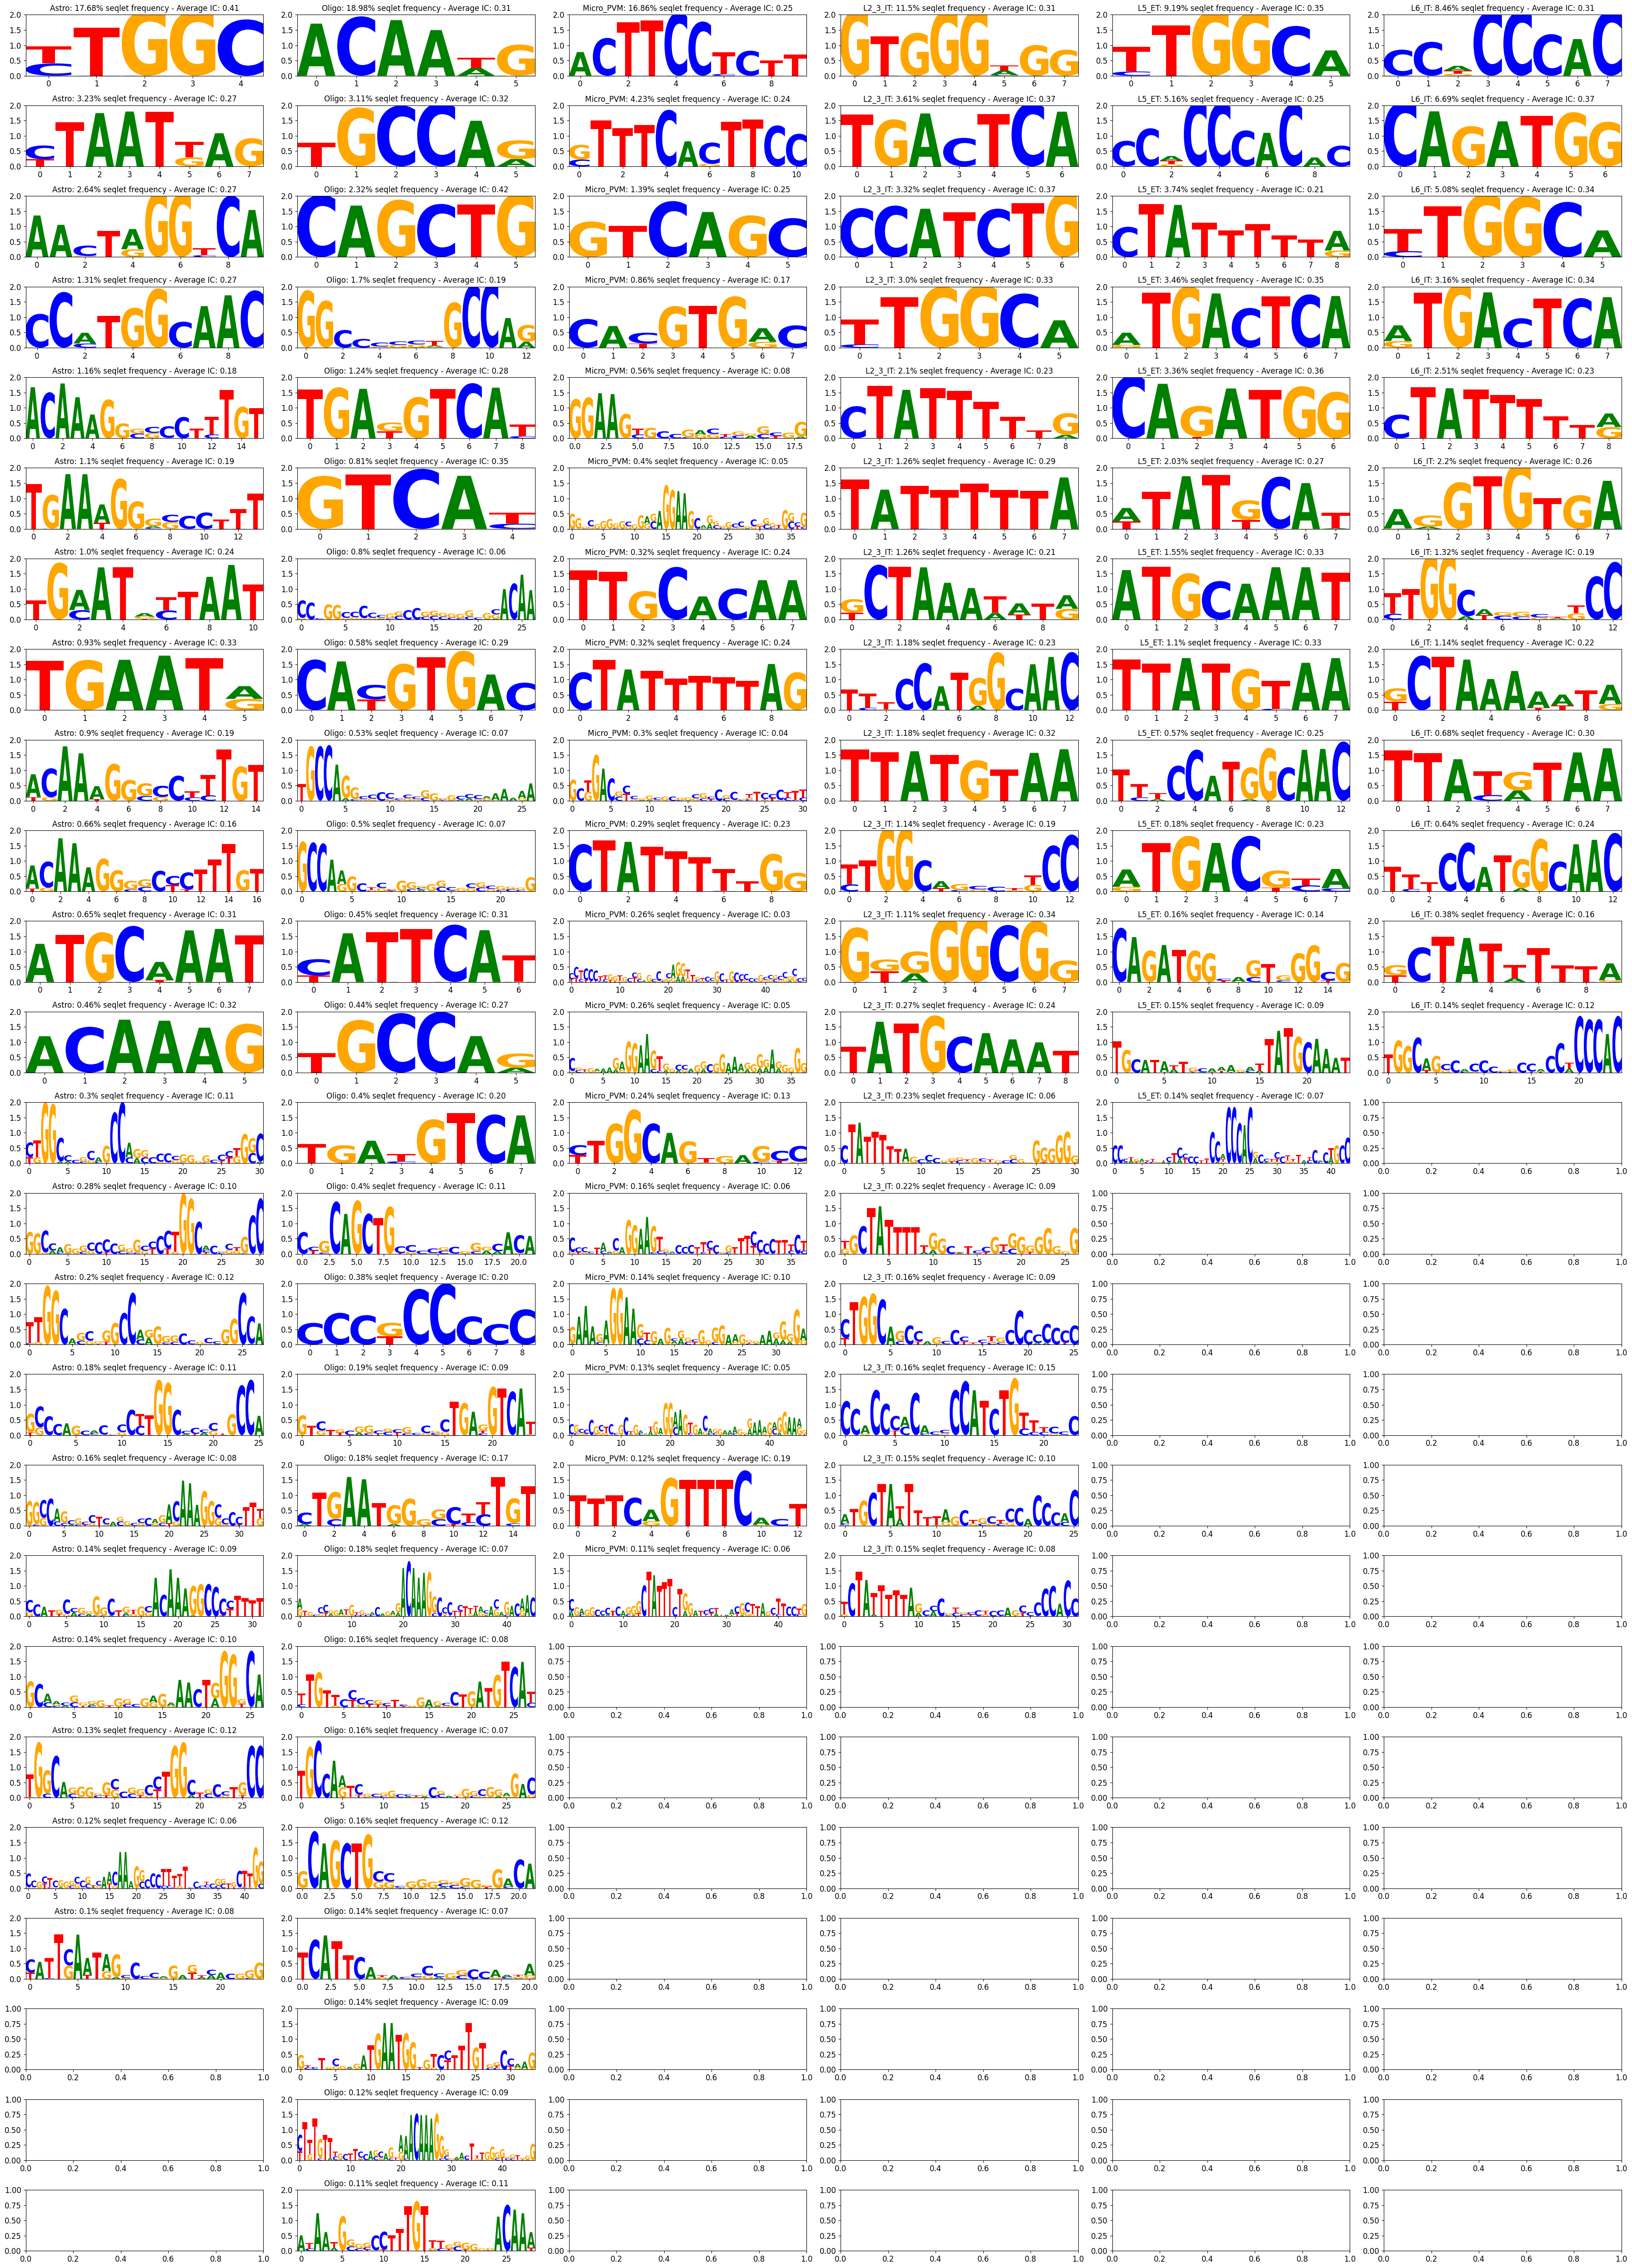

In [8]:
%matplotlib inline
top_k=20000
crested.pl.patterns.modisco_results(
    classes=ct_of_interest,
    contribution="positive",
    contribution_dir="../data/modisco/modisco_results_hydrop/",
    num_seq=top_k,
    y_max=0.15,
    viz="pwm",
    save_path='../data/modisco/hydrop_tfmodisco_positive.png'
)  # You can also visualize in 'pwm' format

## 10x

2025-07-28T11:42:55.671585+0200 INFO Starting genomic contributions plot for classes: ['Astro', 'Oligo', 'Micro_PVM', 'L2_3_IT', 'L5_ET', 'L6_IT']


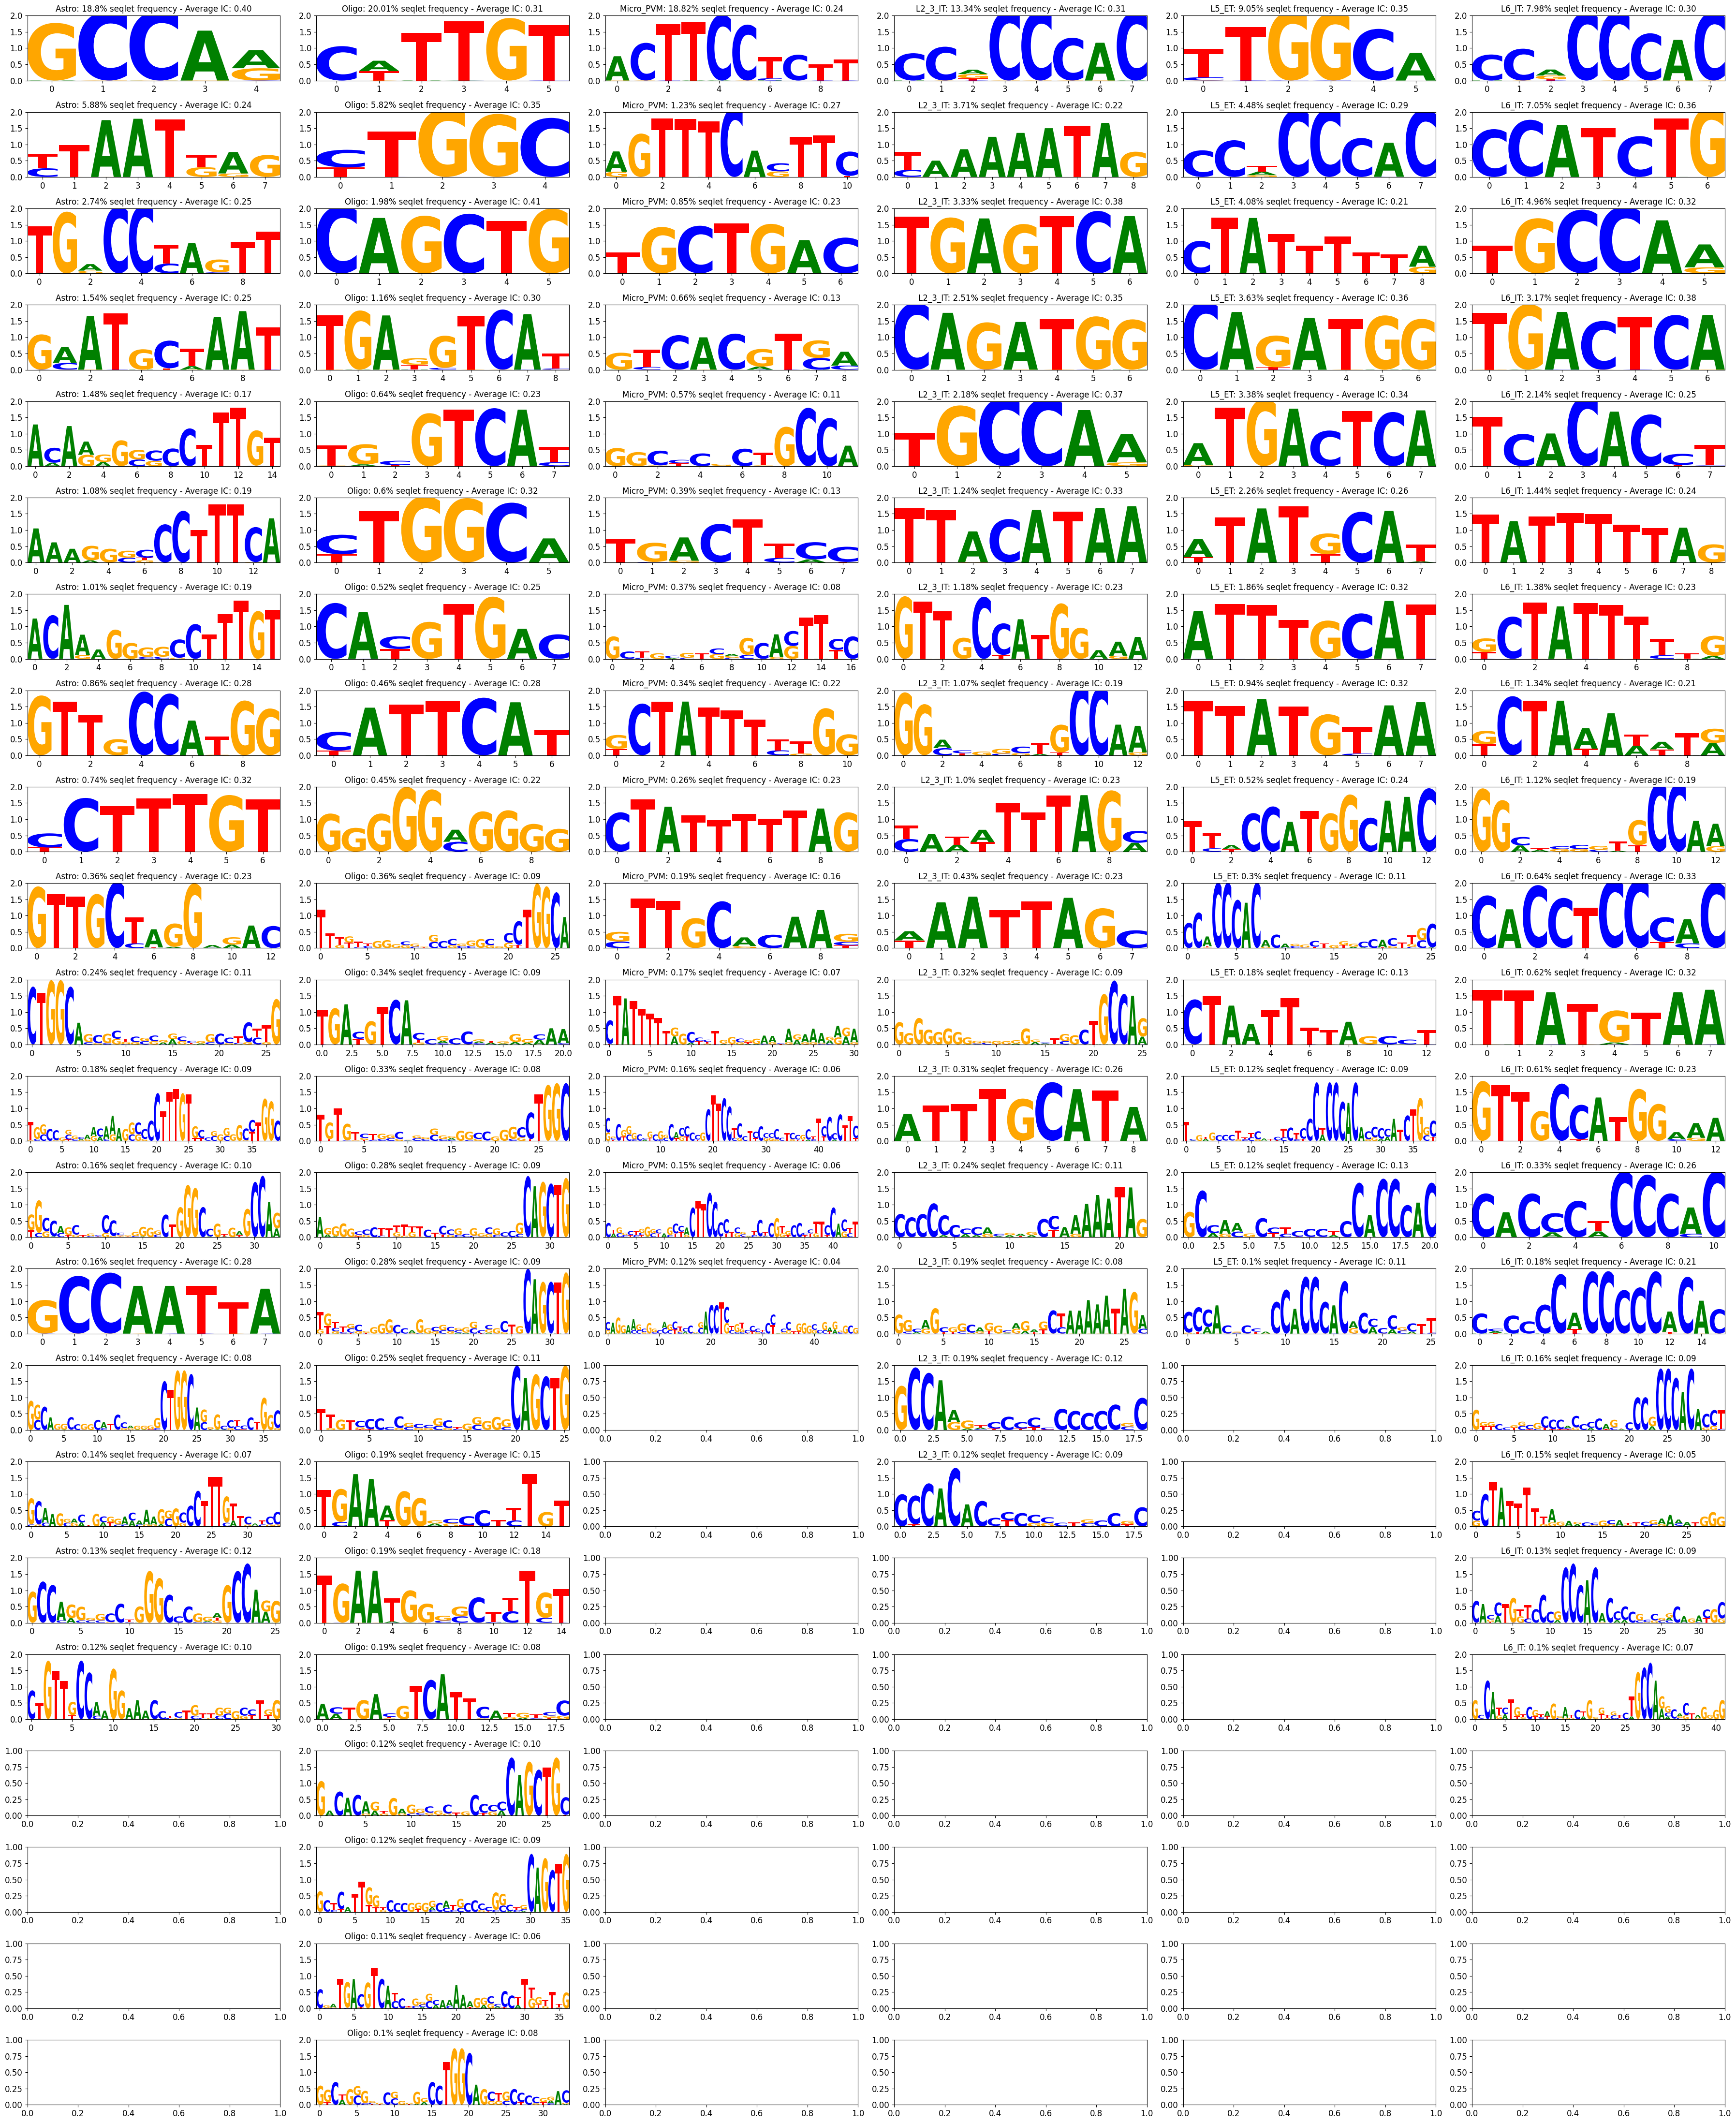

In [9]:
%matplotlib inline
top_k=20000
crested.pl.patterns.modisco_results(
    classes=ct_of_interest,
    contribution="positive",
    contribution_dir="../data/modisco/modisco_results_10x/",
    num_seq=top_k,
    y_max=0.15,
    viz="pwm",
    save_path='../data/modisco/modisco_results_10x/10x_tfmodisco_positive.png'
)  # You can also visualize in 'pwm' format

## Matching patterns

In [10]:
# run in env with tangermeme installed
import crested

In [11]:
%matplotlib inline
import matplotlib
 
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

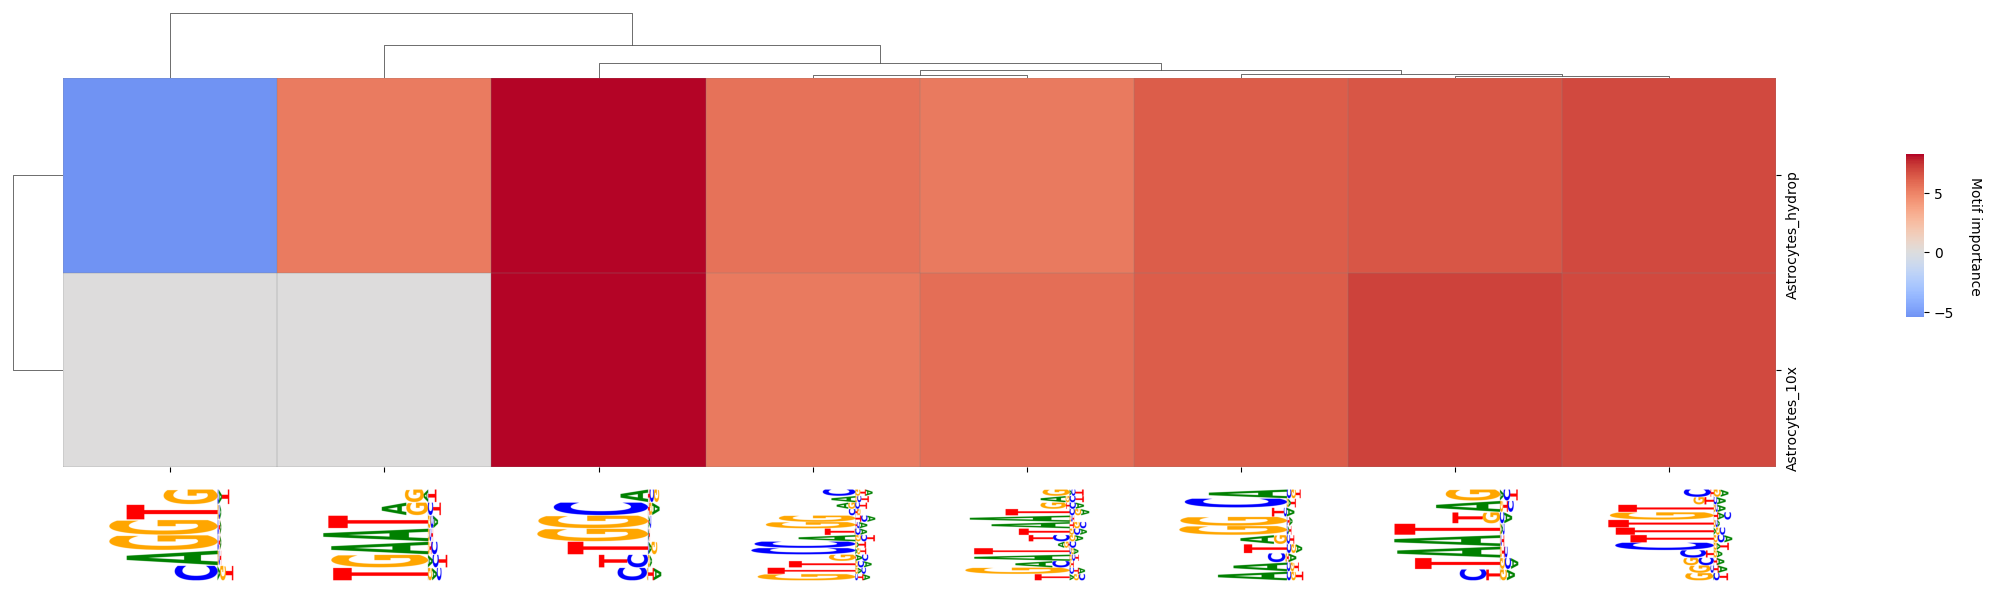

In [14]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "Astrocytes_hydrop": "../data/modisco/modisco_results_hydrop/Astro_modisco_results.h5",
    "Astrocytes_10x": "../data/modisco/modisco_results_10x/Astro_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4.25,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=False,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/Astrocytes.pdf"
)

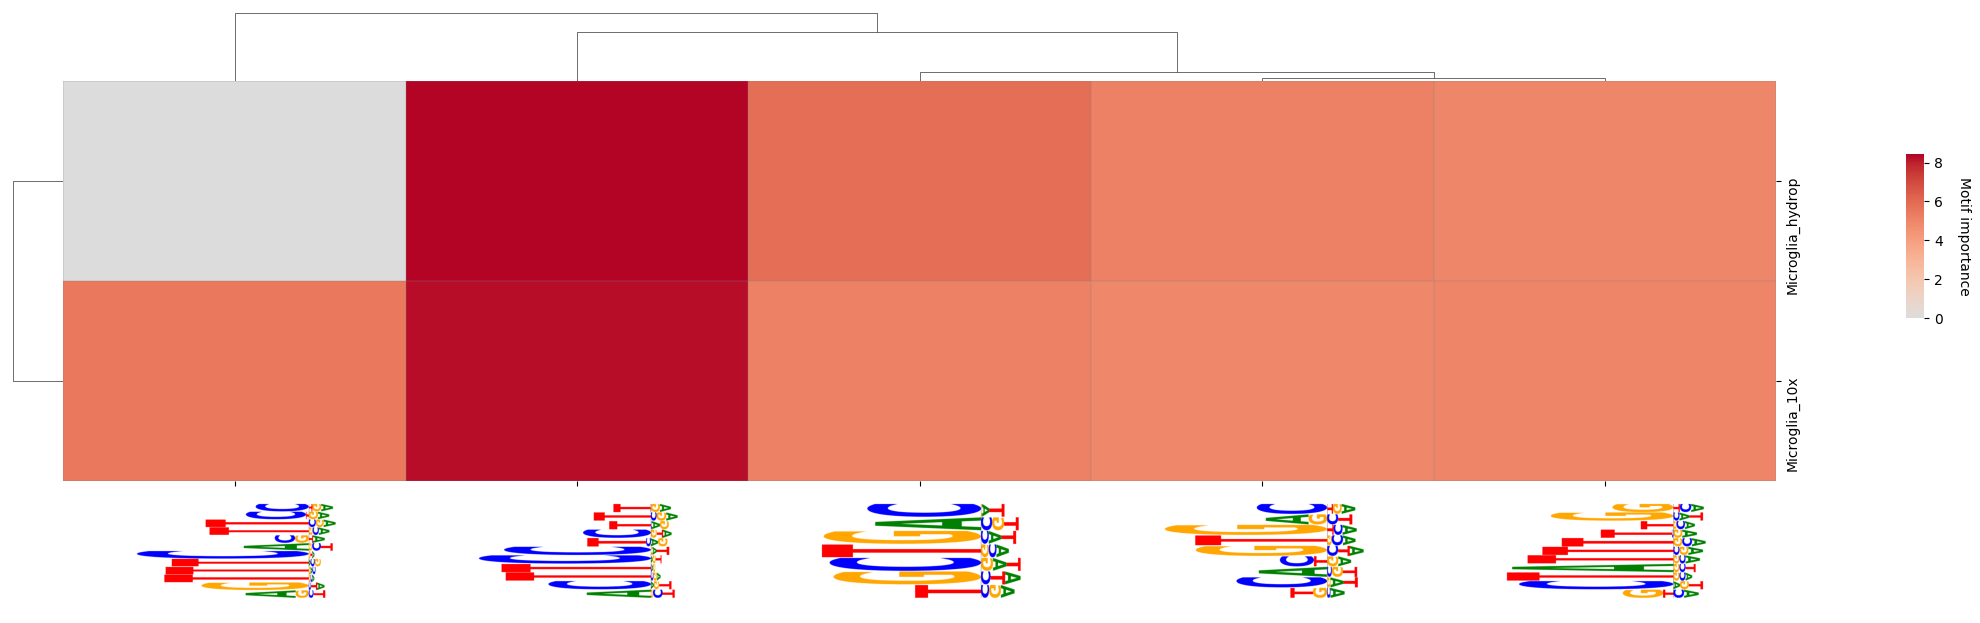

In [16]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "Microglia_hydrop": "../data/modisco/modisco_results_hydrop/Micro_PVM_modisco_results.h5",
    "Microglia_10x": "../data/modisco/modisco_results_10x/Micro_PVM_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=3.25,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=False,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/Microglia.pdf"
)

Reading file ../data/modisco/modisco_results_hydrop/Oligo_modisco_results.h5
Match between Oligodendrocytes_hydrop_pos_patterns_3 and Oligodendrocytes_hydrop_pos_patterns_1 with similarity score 4.81
Match between Oligodendrocytes_hydrop_pos_patterns_8 and Oligodendrocytes_hydrop_pos_patterns_1 with similarity score 6.49
Match between Oligodendrocytes_hydrop_pos_patterns_9 and Oligodendrocytes_hydrop_pos_patterns_1 with similarity score 4.98
Match between Oligodendrocytes_hydrop_pos_patterns_11 and Oligodendrocytes_hydrop_pos_patterns_1 with similarity score 5.42
Match between Oligodendrocytes_hydrop_pos_patterns_12 and Oligodendrocytes_hydrop_pos_patterns_4 with similarity score 4.72
Match between Oligodendrocytes_hydrop_pos_patterns_13 and Oligodendrocytes_hydrop_pos_patterns_2 with similarity score 3.47
Match between Oligodendrocytes_hydrop_pos_patterns_15 and Oligodendrocytes_hydrop_pos_patterns_4 with similarity score 5.59
Match between Oligodendrocytes_hydrop_pos_patterns_17 and 

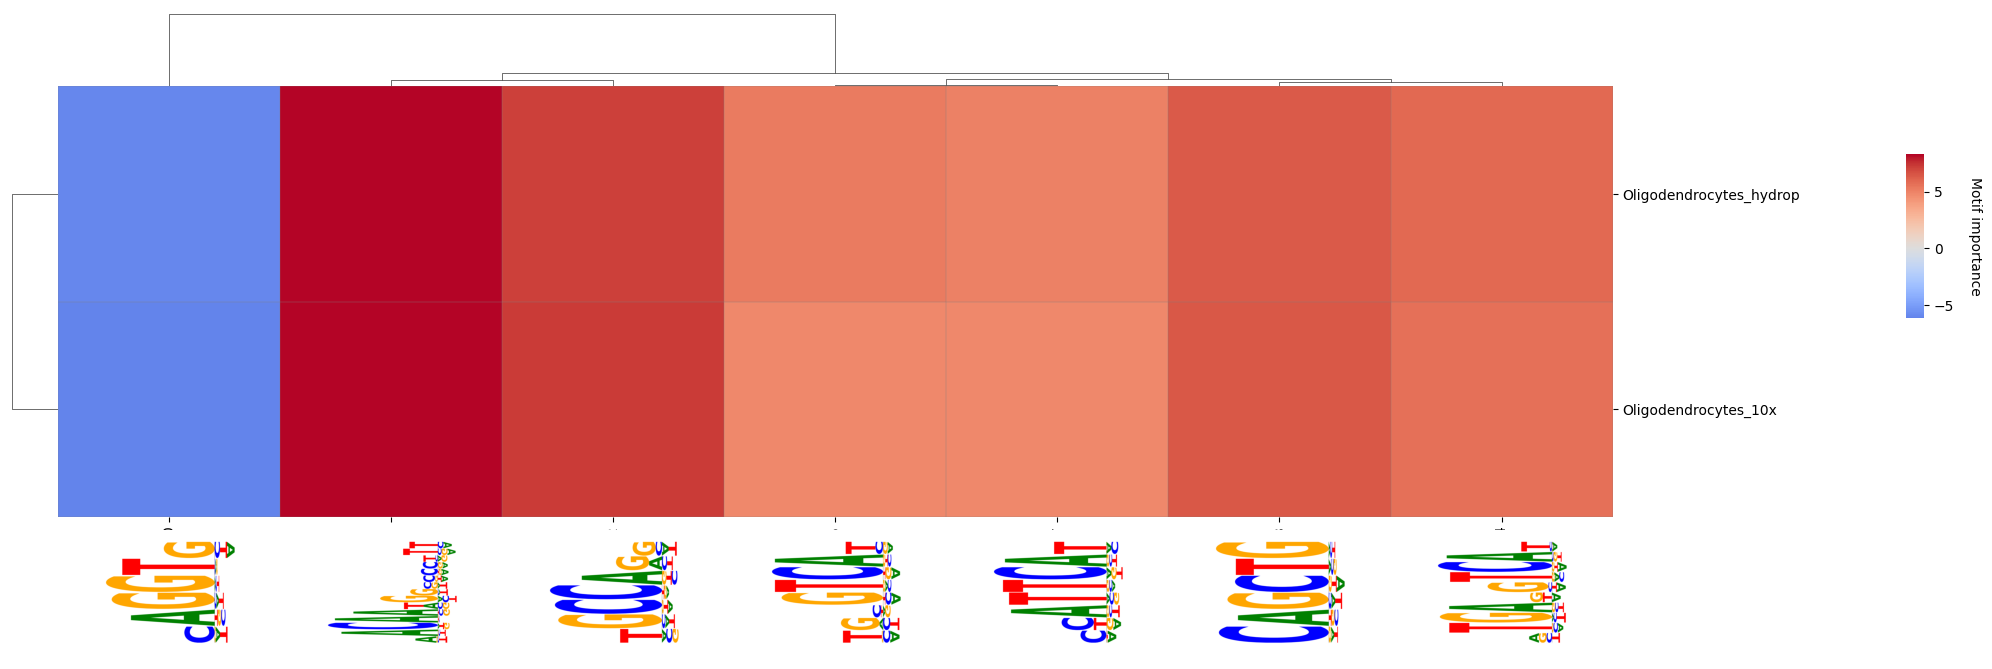

In [17]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "Oligodendrocytes_hydrop": "../data/modisco/modisco_results_hydrop/Oligo_modisco_results.h5",
    "Oligodendrocytes_10x": "../data/modisco/modisco_results_10x/Oligo_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=3,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=True,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/Oligodendrocytes.pdf"
)

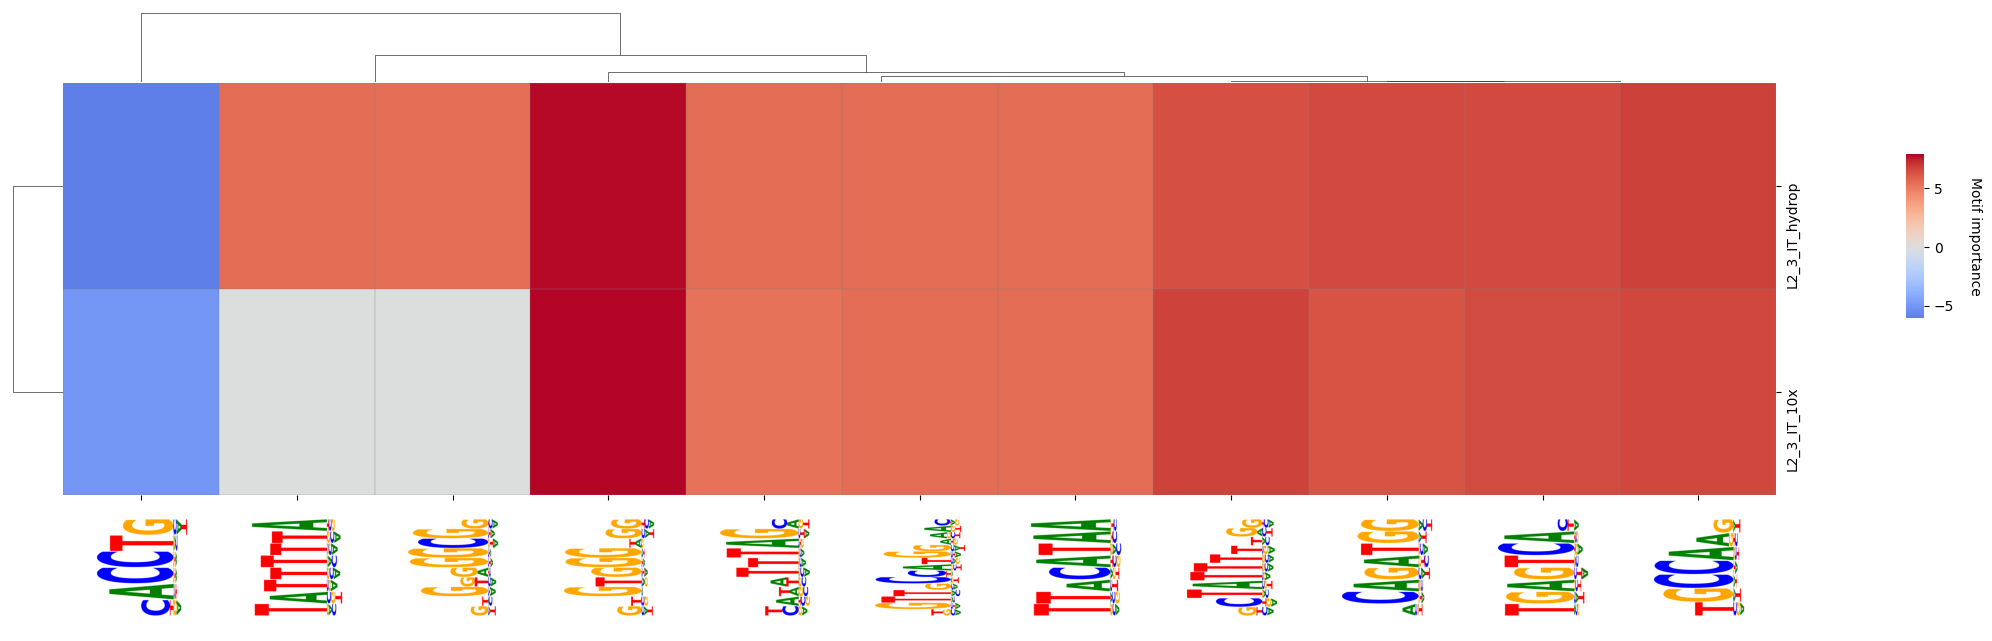

In [19]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "L2_3_IT_hydrop": "../data/modisco/modisco_results_hydrop/L2_3_IT_modisco_results.h5",
    "L2_3_IT_10x": "../data/modisco/modisco_results_10x/L2_3_IT_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4.25,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=False,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/L2_3IT.pdf"
)

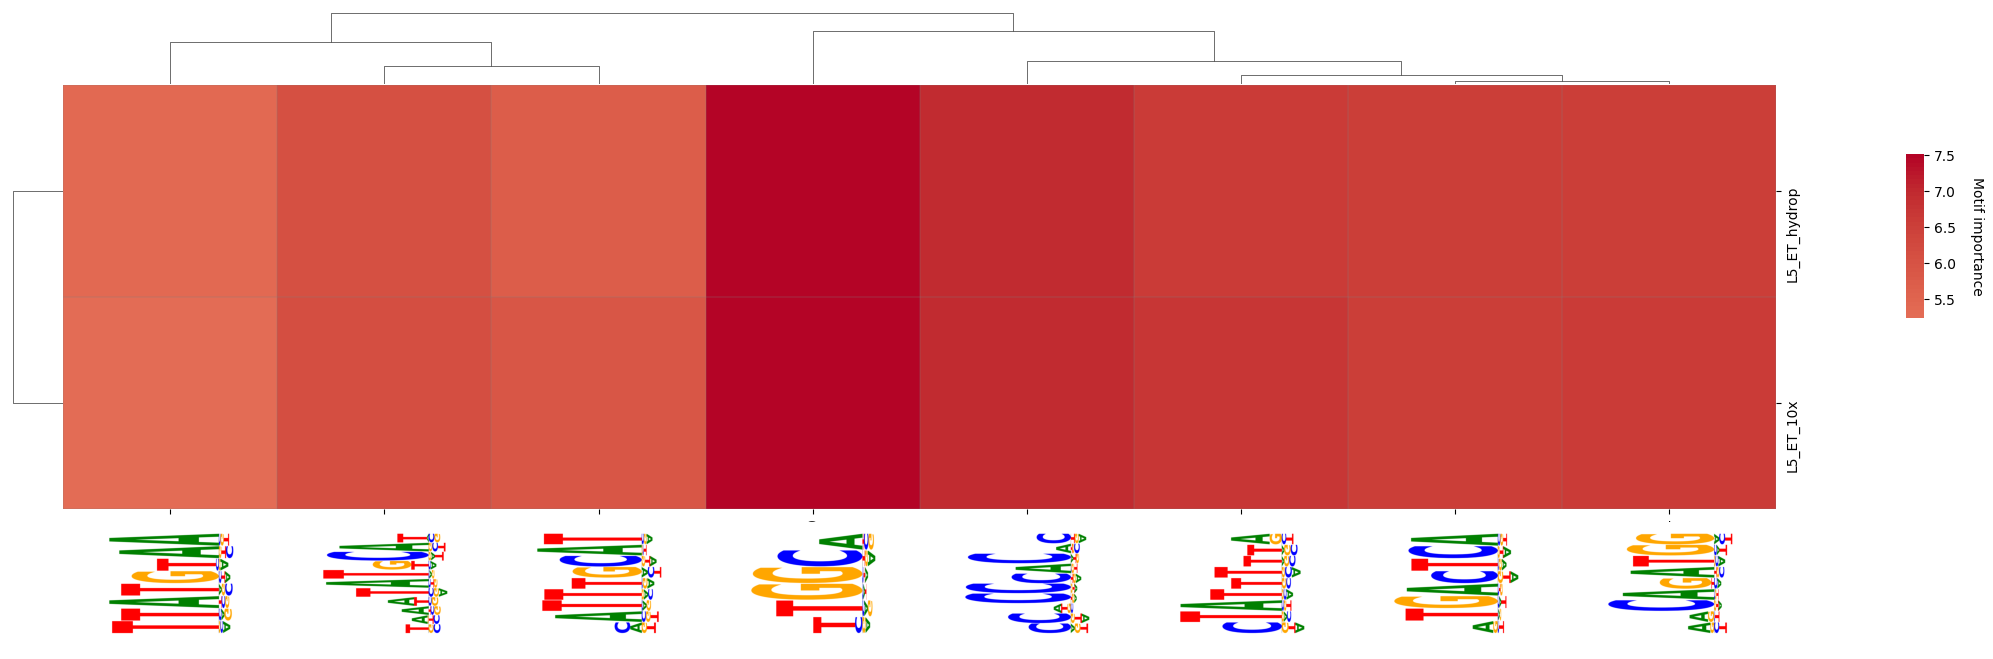

In [21]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "L5_ET_hydrop": "../data/modisco/modisco_results_hydrop/L5_ET_modisco_results.h5",
    "L5_ET_10x": "../data/modisco/modisco_results_10x/L5_ET_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4.25,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=False,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/L5_ET.pdf"
)

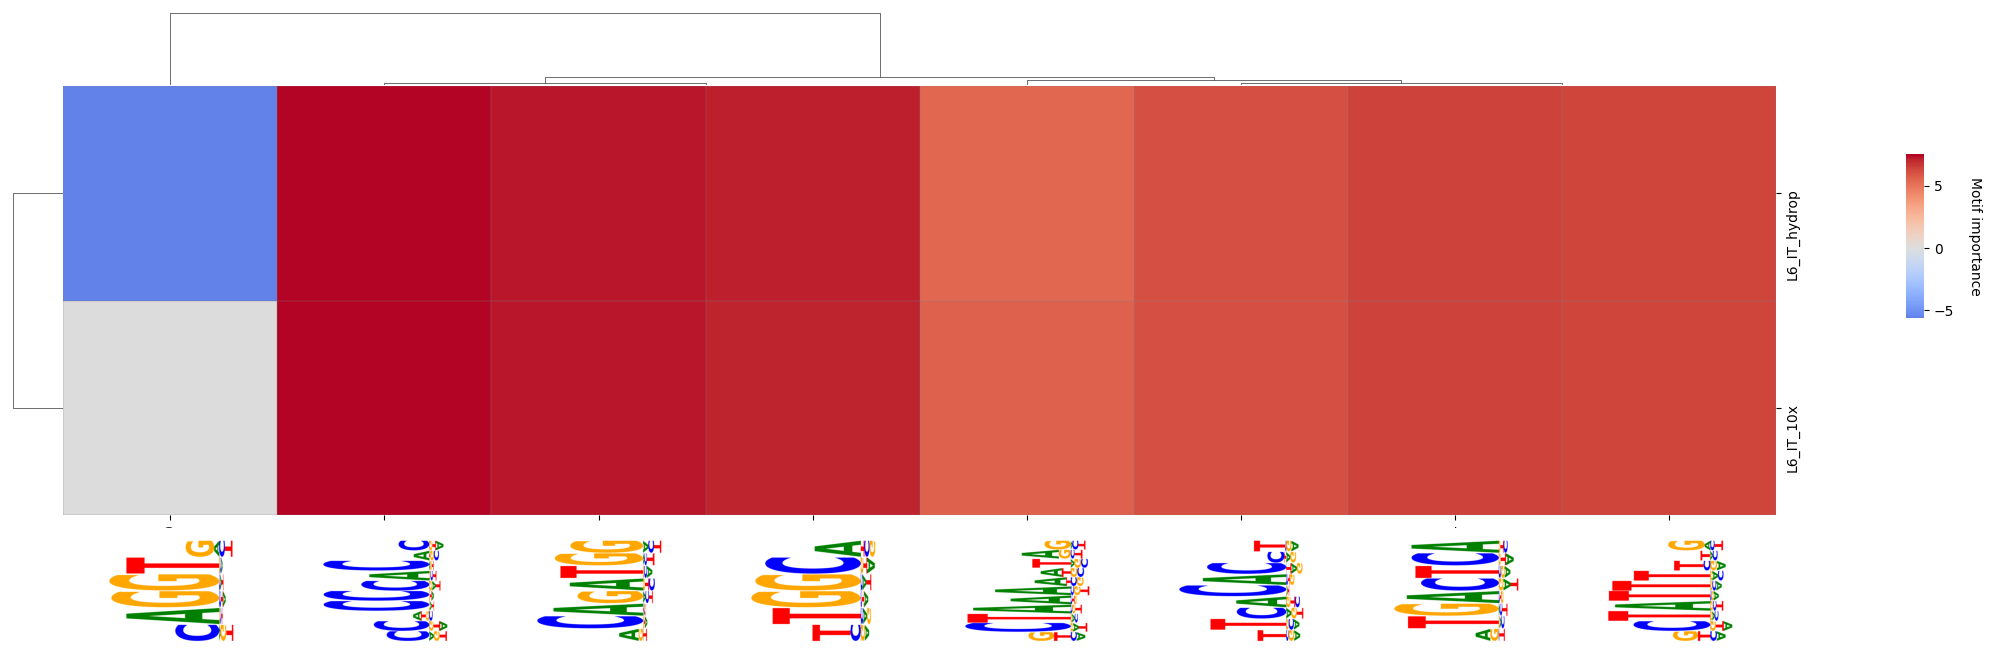

In [23]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
matched_files = {
    "L6_IT_hydrop": "../data/modisco/modisco_results_hydrop/L6_IT_modisco_results.h5",
    "L6_IT_10x": "../data/modisco/modisco_results_10x/L6_IT_modisco_results.h5",
}

all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=3,  
    trim_ic_threshold=0.05,  
    discard_ic_threshold=0.2,  
    verbose=False,  
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(matched_files.keys()),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix,
    list(matched_files.keys()),
    pattern_dict=all_patterns,
    figsize=(18.2, 4.2),
    grid=True,
    dendrogram_ratio=(0.03, 0.15),
    importance_threshold=5, 
    logo_height_fraction=0.3,
    logo_y_padding=0.1,
    save_path = "../data/modisco/clustermaps/L6_IT.pdf"
)